# 앙상블(Ensemble) 모델
머신러닝 앙상블이란? **여러개의 머신러닝 모델을 이용해 최적의 답을 찾아내는 기법**
* 여러 모델을 이용하여 데이터를 학습하고, 모든 모델의 예측결과를 **평균**하여 예측

## 앙상블 모델의 종류
* 보팅 (Voting) : 투표를 통해 결과를 도출
* 배깅 (Bagging) : 샘플 중복 생성을 통해 결과 도출
* 부스팅 (Boosting) : 이전 오차를 보완하면서 가중치를 부여
* 스태킹 (Stacking) : 여러 모델을 기반으로 예측된 결과를 통해 **meta** 모델이 다시 한번 예측

# 데이터셋 로딩

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from sklearn.datasets import load_boston

data = load_boston()

# 데이터프레임 생성

In [ ]:
df = pd.DataFrame(
    data['data'],
    columns=data['feature_names']
)
df['MEDV'] = data['target']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Train / Test 쪼개기

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("MEDV", 1),
    df["MEDV"],
    random_state=42
)

In [ ]:
X_train.shape, y_train.shape

((379, 13), (379,))

# 평가지표 만들기

## MSE( Mean Squared Error )
$$
\frac{1}{N}\sum_{i=1}^N(\hat{y_i} - t_i)^2
$$
예측값 $\hat{y}$와 실제값($t$)사이의 오차 **제곱**의 평균

## MAE ( Mean Absolute Error )
$$
\frac{1}{N}\sum_{i=1}^N\left | \hat{y_i}-t_i  \right|
$$

예측값 $\hat{y}$와 실제값($t$)사이의 오차 **절대값**의 평균

## RMSE ( Root Mean Squared Error )
$$
\sqrt{\frac{1}{N}\sum_{i=1}^N(\hat{y_i} - t_i)^2}
$$

MSE에 root를 씌운 값

### sklearn의 평가지표 활용하기

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

### 모델별 성능 확인을 위한 함수 추가


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def mse_eval(name_, pred, actual):
    global predictions
    global colors

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

def plot_coef(columns, coef):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.show()

# 단일 회귀예측 모델

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

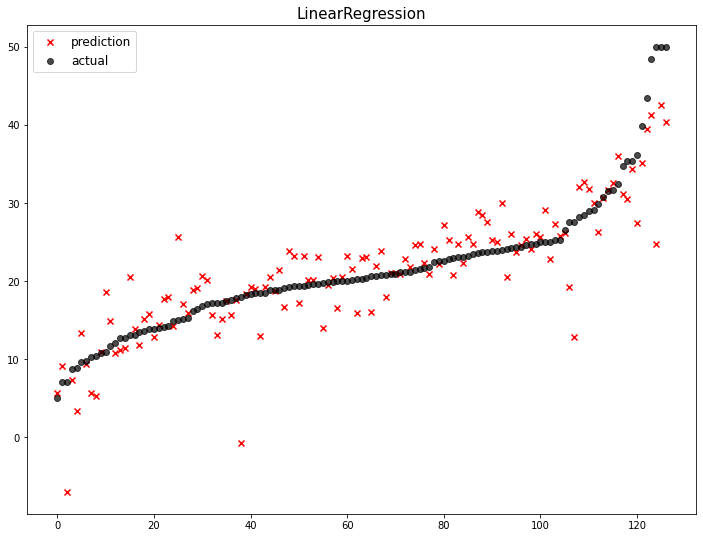

              model        mse
0  LinearRegression  22.098695


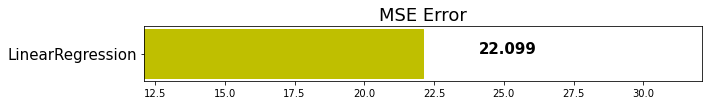

In [ ]:
lin = LinearRegression()
lin.fit(X_train, y_train)

pred = lin.predict(X_test)
mse_eval("LinearRegression", pred, y_test)

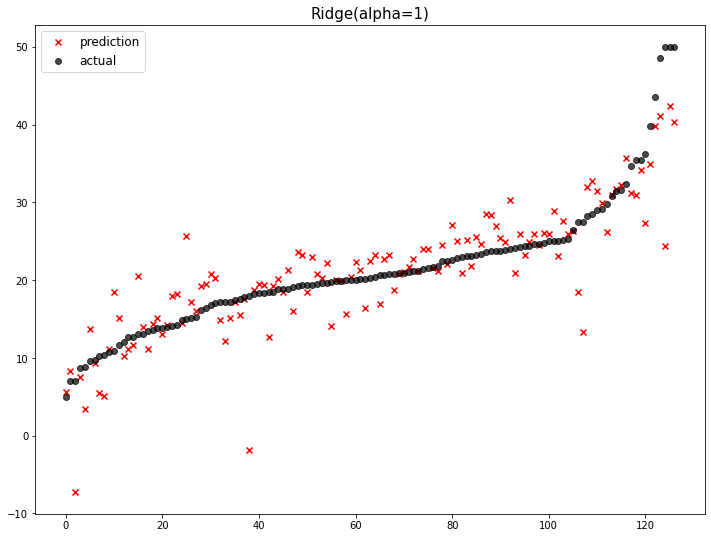

              model        mse
0    Ridge(alpha=1)  22.480476
1  LinearRegression  22.098695


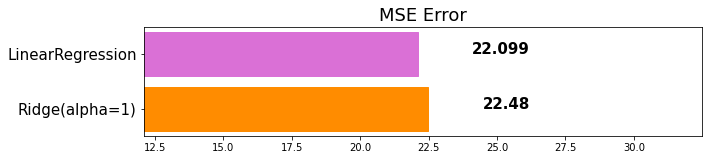

In [ ]:
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)

pred = ridge.predict(X_test)
mse_eval("Ridge(alpha=1)", pred, y_test)

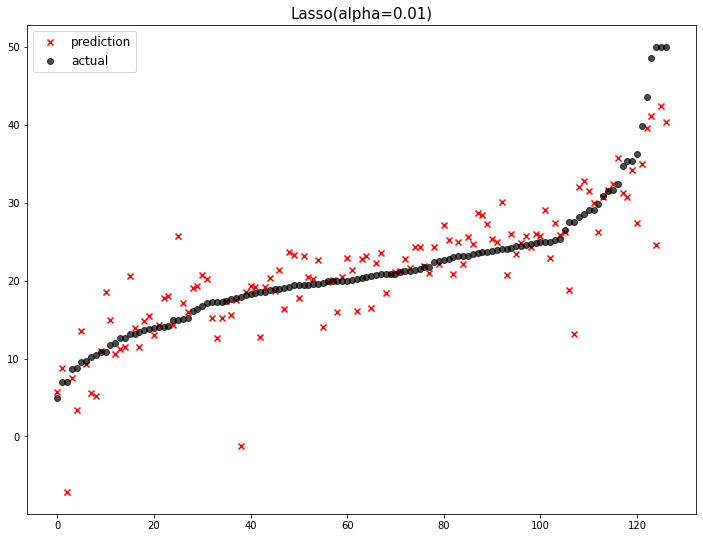

               model        mse
0     Ridge(alpha=1)  22.480476
1  Lasso(alpha=0.01)  22.210557
2   LinearRegression  22.098695


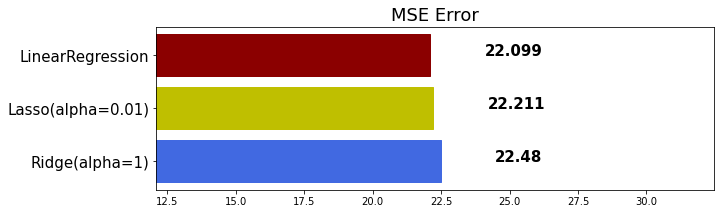

In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

pred = lasso.predict(X_test)
mse_eval("Lasso(alpha=0.01)", pred, y_test)

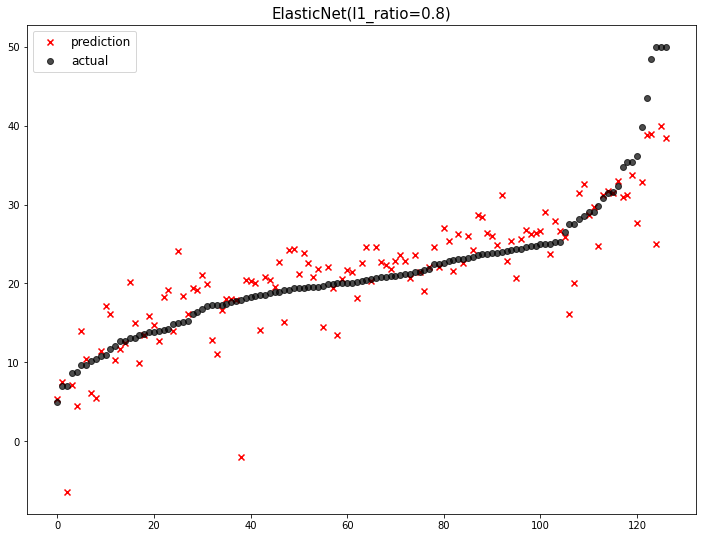

                      model        mse
0  ElasticNet(l1_ratio=0.8)  23.156236
1            Ridge(alpha=1)  22.480476
2         Lasso(alpha=0.01)  22.210557
3          LinearRegression  22.098695


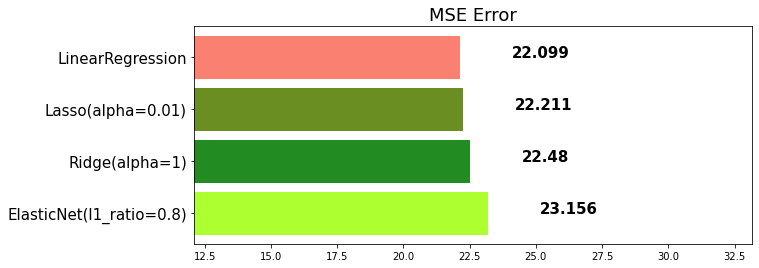

In [ ]:
elastic_net = ElasticNet(alpha=0.5, l1_ratio=0.8)
elastic_net.fit(X_train, y_train)

pred = elastic_net.predict(X_test)
mse_eval("ElasticNet(l1_ratio=0.8)", pred, y_test)

# 앙상블(Ensemble)

## 1. 보팅 (Voting) 회귀( Regression )
**투표를 통해 결정하는 방식**
* Voting은 서로 다른 알고리즘 모델을 조합해서 사용
* Bagging은 같은 알고리즘 내에서 다른 샘플 조합을 사용

In [ ]:
from sklearn.ensemble import VotingRegressor, VotingClassifier

반드시 **Tuple 형태로 모델을 정의**

In [ ]:
single_models = [
  ('linear_reg', lin),
  ('my_ridge', ridge),
  ('your_lasso', lasso),
  ('our_elastic', elastic_net)
]

voting_regressor = VotingRegressor(
    single_models,
    n_jobs = -1
)

In [ ]:
voting_regressor.fit(X_train, y_train)

VotingRegressor(estimators=[('linear_reg',
                             LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False)),
                            ('my_ridge',
                             Ridge(alpha=1, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001)),
                            ('your_lasso',
                             Lasso(alpha=0.01, copy_X=True, fit_intercept=True,
                                   max_iter=1000, normalize=False,
                                   positive=False, precompute=False,
                                   random_state=None, selection='cyclic',
                                   tol=0.0001, warm_start=False)),
                            ('our_elastic',
                             ElasticNet(alpha=0.5, cop

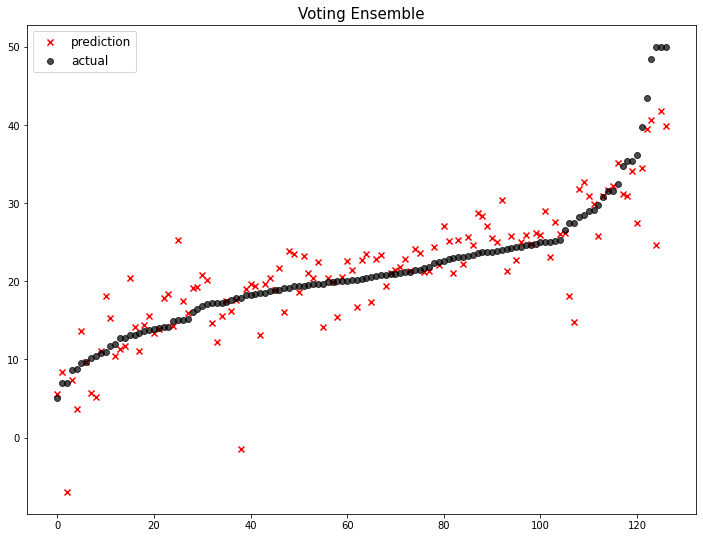

                      model        mse
0  ElasticNet(l1_ratio=0.8)  23.156236
1            Ridge(alpha=1)  22.480476
2         Lasso(alpha=0.01)  22.210557
3          LinearRegression  22.098695
4           Voting Ensemble  22.040224


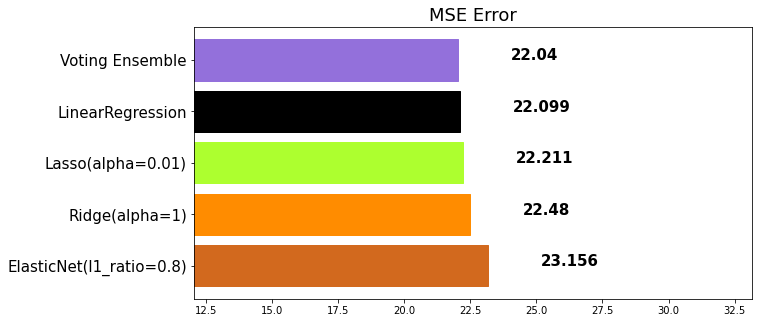

In [ ]:
voting_pred = voting_regressor.predict(X_test)
mse_eval("Voting Ensemble", voting_pred, y_test)

## 2. 보팅(Voting) 분류 (Classification)
`voting={'hard', 'soft'}` 하이퍼 파라미터가 제일 중요!

* **hard voting**
  * 결과 값에 대한 다수 class를 차용
  * 분류에 대한 예측값이 `[1,1,0,0,1]` 나온 경우 `1`번 클래스로 예측한게 다수니까 `1`로 결정 된다.

* **soft voting**
  * 각 클래스의 확률의 평균 값을 계산하고, 그 평균값이 가장 높은 값으로 차용
  * 5개의 모델을 앙상블해서 나온 클래스 0이 나올 확률 : `[0.4, 0.9, 0.9, 0.4, 0.4]`
    * 0번 클래스로 결정될 평균 확률 : `(0.4 + 0.9 + 0.9 + 0.4 + 0.4) / 5 = 0.60`
  * 5개의 모델을 앙상블해서 나온 클래스 1이 나올 확률 : `[0.6, 0.1, 0.1, 0.6, 0.6]`
    * 1번 클래스로 결정될 평균 확률 : `(0.6 + 0.1 + 0.1 + 0.6 + 0.6) / 5 = 0.40`

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

models = [
  ("logistic", LogisticRegression()),
  ("svc", SVC())
]

vc = VotingClassifier(models, voting='hard')
vc = VotingClassifier(models, voting='soft')

# 배깅( Bagging )

Bagging : **Boostrap Aggregating**의 줄임말
* Bootstrap = Sample + Aggregating = 합산

Bootstrap은 여러 개의 데이터 세트를 중첩을 허용하게 하여 샘플링을 분할하는 방식

## 부트스트랩 샘플링
원본 데이터 세트의 구성이 `[1,2,3,4,5]` -> `feature가 1,2,3,4,5`

1. group 1 = `[1,2,3]`
2. group 2 = `[3,4,5]`
3. group 3 = `[2,3,5]`

위 처럼 선택된 샘플을 이용해서 모델을 만드는 방식 - Bagging

**Voting VS Bagging**
* Voting은 여러 알고리즘의 조합에 대한 앙상블
* Bagging은 하나의 단일 알고리즘에 대하여 여러 개의 샘플 조합으로 앙상블

## RandomForest
* DecisionTree 기반 Bagging 앙상블
* 굉장히 인기 있는 알고리즘
  - SNOW 어플의 초창기 버젼이 RandomForest로 만들어 졌음
* 사용하기도 쉽고, 성능도 우수하다.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

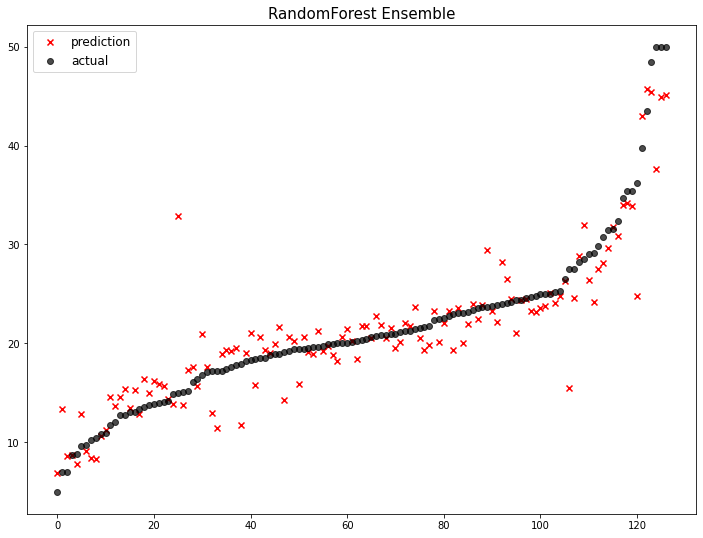

                      model        mse
0  ElasticNet(l1_ratio=0.8)  23.156236
1            Ridge(alpha=1)  22.480476
2         Lasso(alpha=0.01)  22.210557
3          LinearRegression  22.098695
4           Voting Ensemble  22.040224
5     RandomForest Ensemble  10.761387


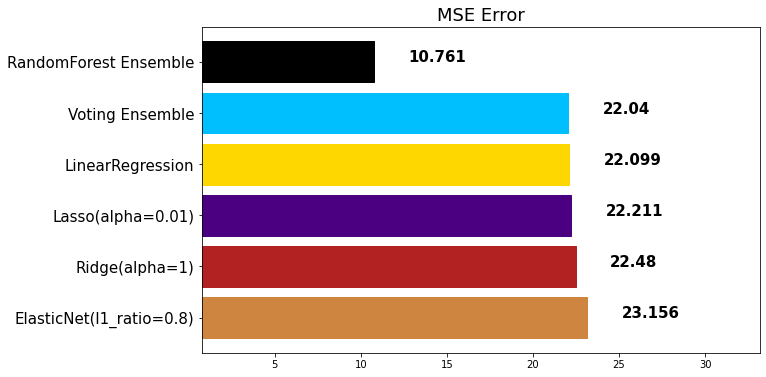

In [ ]:
rfr_pred = rfr.predict(X_test)
mse_eval("RandomForest Ensemble", rfr_pred, y_test)

## BaggingRegressor

In [ ]:
from sklearn.ensemble import BaggingRegressor

bag_reg = BaggingRegressor(base_estimator=Lasso())
bag_reg

BaggingRegressor(base_estimator=Lasso(alpha=1.0, copy_X=True,
                                      fit_intercept=True, max_iter=1000,
                                      normalize=False, positive=False,
                                      precompute=False, random_state=None,
                                      selection='cyclic', tol=0.0001,
                                      warm_start=False),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
                 random_state=None, verbose=0, warm_start=False)

# 부스팅(Boosting)
Weak Learner (약한 학습기)를 여러개 이어 붙여서 점점 오차를 보완해 나가는 방식
* 약한 학습기를 순차적으로 학습을 시켜서, 이전 학습에 대해서 잘못 예측한 데이터에 대해서 **가중치**를 부여하가면서 오차를 보완해 나가는 방식

## 장점
  * 성능이 매우 우수하다.

## 단점
  * 오분류 / 잔차 를 보완하려고 하기 때문에 **잘못된 레이블링이나 아웃라이어에 필요 이상으로 민감하다.**
  * 다른 앙상블 기법 대비 **학습 시간이 오래걸린다**

**대표적인 Boosting 앙상블**
1. AdaBoost
2. GradientBoost
3. LightGBM (LGBM)
4. XGBoost

## GradientBoost
* 성능이 우수
* 학습시간이 너무 오래 걸린다.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

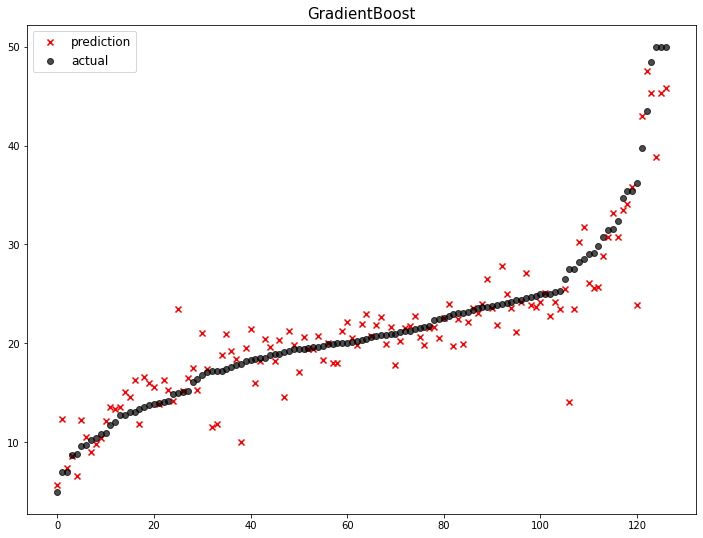

                      model        mse
0  ElasticNet(l1_ratio=0.8)  23.156236
1            Ridge(alpha=1)  22.480476
2         Lasso(alpha=0.01)  22.210557
3          LinearRegression  22.098695
4           Voting Ensemble  22.040224
5     RandomForest Ensemble  10.761387
6             GradientBoost   8.956141


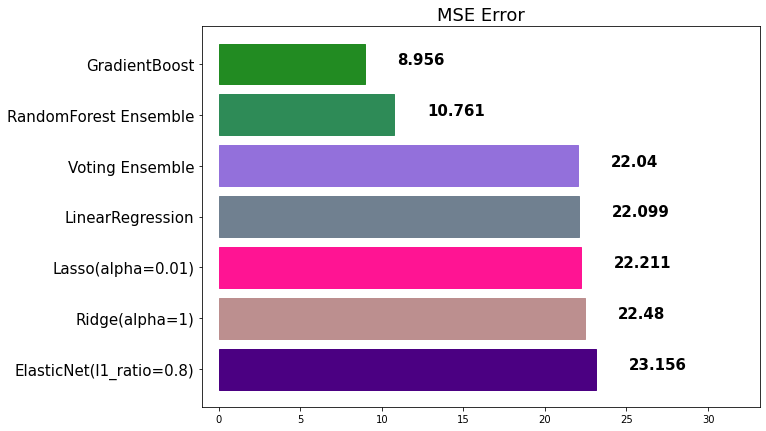

In [ ]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

gbr_pred = gbr.predict(X_test)
mse_eval("GradientBoost", gbr_pred, y_test)

## XGBoost (eXtream Gradient Boosting)
* 사이킷런 패키지가 아님!
* 성능이 우수
* GBM보다는 빠르고, 성능도 향상 되었다.
* 학습 시간은 여전히 느리다.

In [ ]:
from xgboost import XGBRegressor, XGBClassifier

[02:18:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


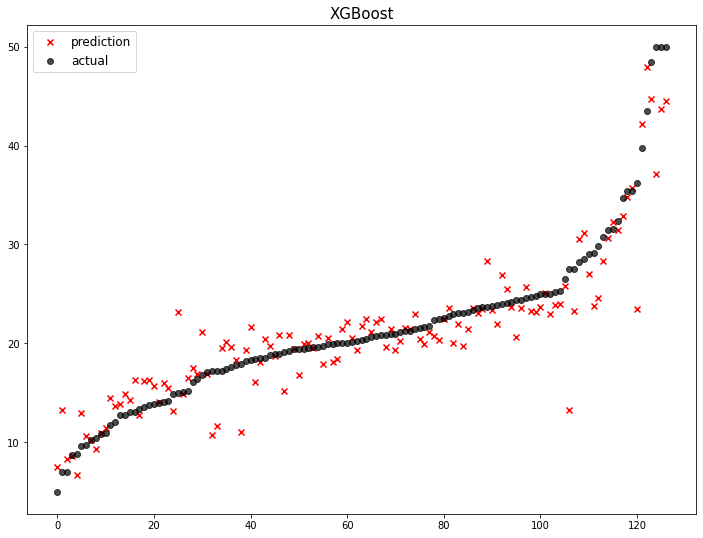

                      model        mse
0  ElasticNet(l1_ratio=0.8)  23.156236
1            Ridge(alpha=1)  22.480476
2         Lasso(alpha=0.01)  22.210557
3          LinearRegression  22.098695
4           Voting Ensemble  22.040224
5     RandomForest Ensemble  10.761387
6                   XGBoost  10.118980
7             GradientBoost   8.956141


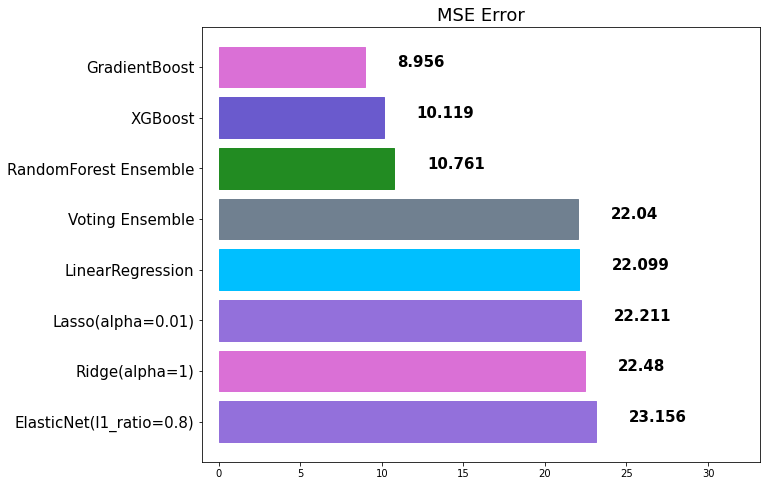

In [ ]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
mse_eval("XGBoost", xgb_pred, y_test)

## LightGBM
* 사이킷런 패키지가 아님
* 성능이 우수
* 속도가 빠르다

In [ ]:
from lightgbm import LGBMRegressor, LGBMClassifier

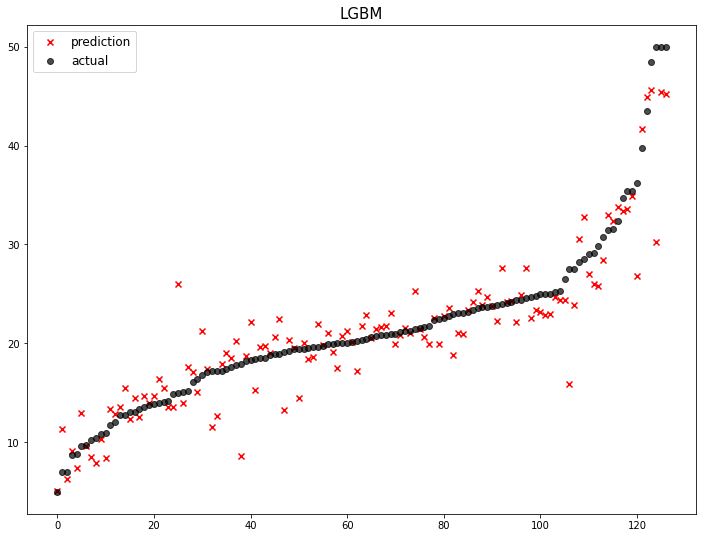

                      model        mse
0  ElasticNet(l1_ratio=0.8)  23.156236
1            Ridge(alpha=1)  22.480476
2         Lasso(alpha=0.01)  22.210557
3          LinearRegression  22.098695
4           Voting Ensemble  22.040224
5                      LGBM  10.937726
6     RandomForest Ensemble  10.761387
7                   XGBoost  10.118980
8             GradientBoost   8.956141


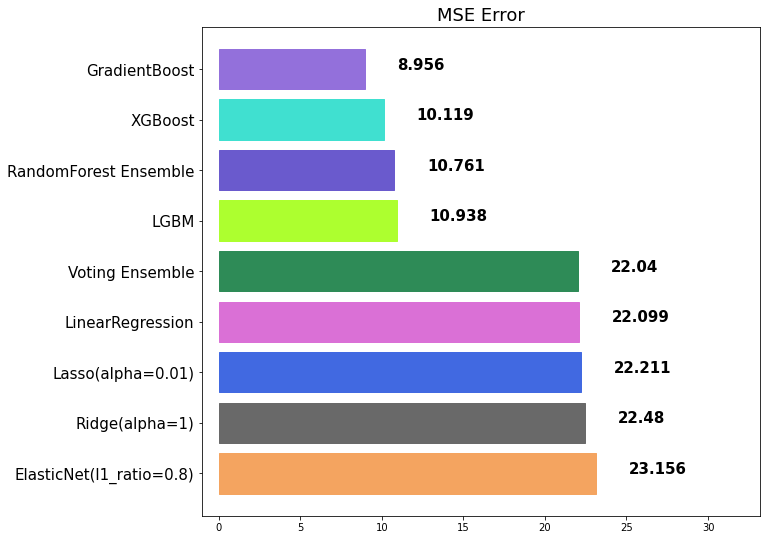

In [ ]:
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

lgbm_pred = lgbm.predict(X_test)
mse_eval("LGBM", lgbm_pred, y_test)

## AdaBoost

Adaptive + Boosting (적응형 부스팅 방식)
* LightGBM, XGBoost : GB에서 평가방식을 튜닝한 모델
* 학습률( learning rate ) 학습에 따라서 조절

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

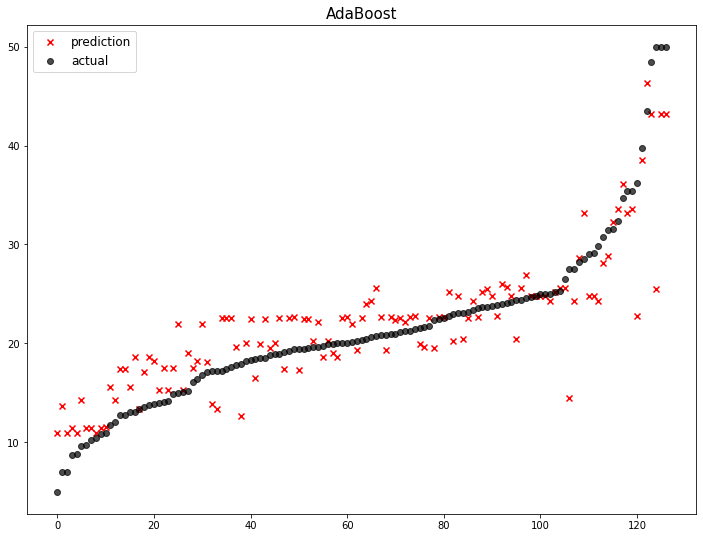

                      model        mse
0  ElasticNet(l1_ratio=0.8)  23.156236
1            Ridge(alpha=1)  22.480476
2         Lasso(alpha=0.01)  22.210557
3          LinearRegression  22.098695
4           Voting Ensemble  22.040224
5                  AdaBoost  16.028607
6                      LGBM  10.937726
7     RandomForest Ensemble  10.761387
8                   XGBoost  10.118980
9             GradientBoost   8.956141


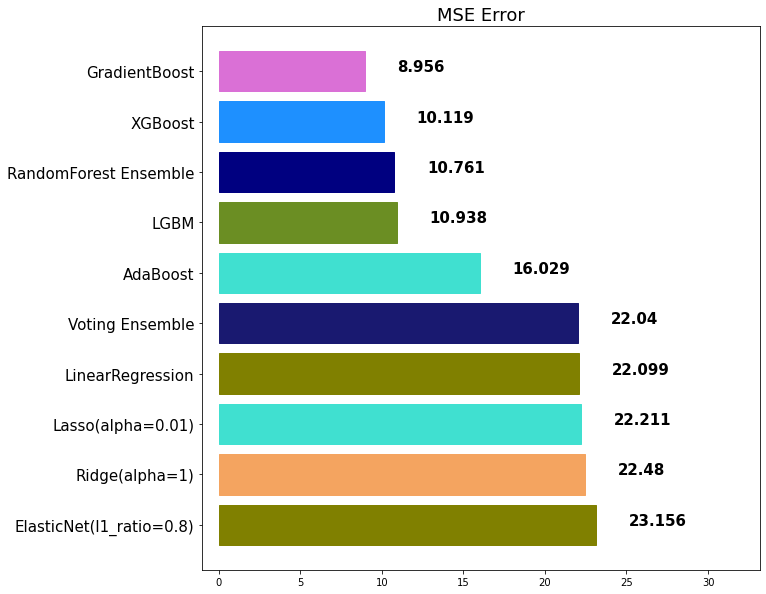

In [ ]:
adr = AdaBoostRegressor(random_state=42)
adr.fit(X_train, y_train)

adr_pred = adr.predict(X_test)
mse_eval("AdaBoost", adr_pred, y_test)

## Stacking

개별 모델이 예측한 데이터를 기반으로 **final_estimator**가 종합해서 예측을 수행한다.

* 성능을 극한까지 끌어올리고 싶을 때 사용
* 데이터 세트가 작을 경우 과대적합의 위험이 있다.

In [ ]:
from sklearn.ensemble import StackingClassifier, StackingRegressor

In [ ]:
stack_models = [
  ('randomforest', rfr),
  ('gbr', gbr),
  ('lgbm', lgbm)
]

In [ ]:
stack_reg = StackingRegressor(stack_models, final_estimator=xgb, n_jobs=-1)

[02:44:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


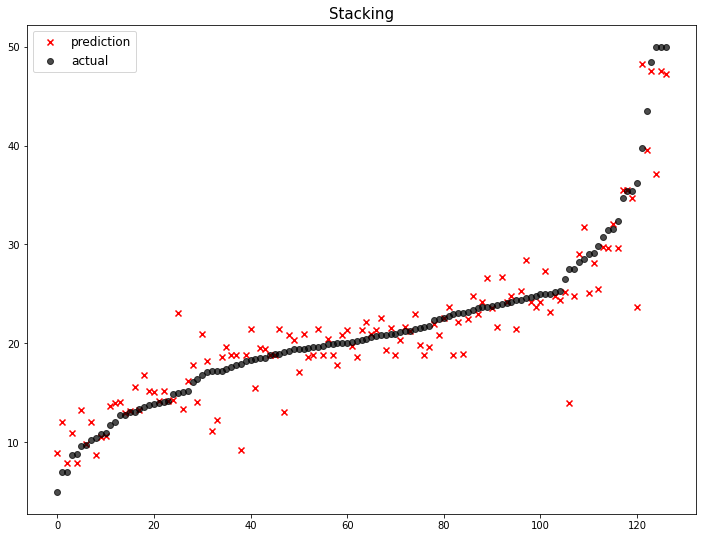

                       model        mse
0   ElasticNet(l1_ratio=0.8)  23.156236
1             Ridge(alpha=1)  22.480476
2          Lasso(alpha=0.01)  22.210557
3           LinearRegression  22.098695
4            Voting Ensemble  22.040224
5                   AdaBoost  16.028607
6                       LGBM  10.937726
7      RandomForest Ensemble  10.761387
8                    XGBoost  10.118980
9                   Stacking   9.786515
10             GradientBoost   8.956141


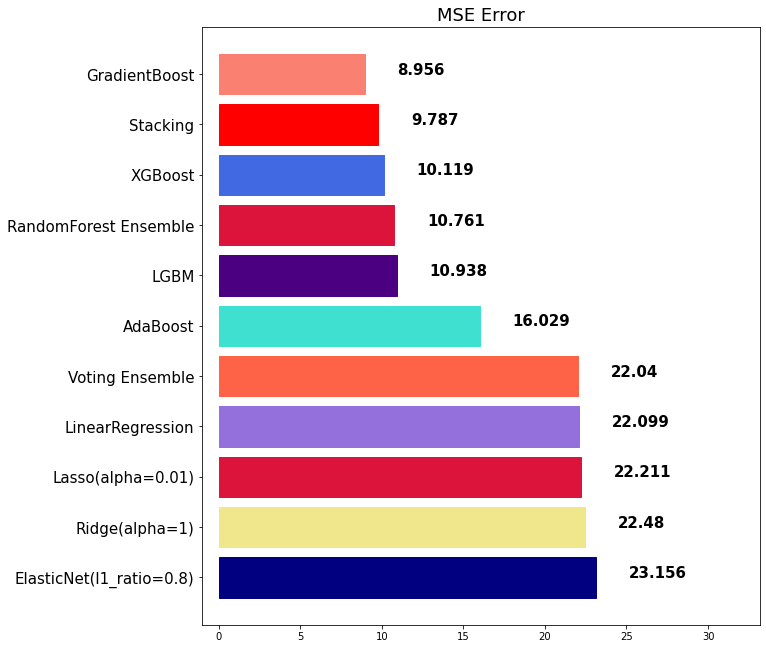

In [ ]:
stack_reg.fit(X_train, y_train)
stack_pred = stack_reg.predict(X_test)
mse_eval("Stacking", stack_pred, y_test)

# Weighted Blending

각 모델의 예측값에 대하여 **가중치(weight)**를 부여하여(곱하여) 최종 output 계산
* 모델에 대한 가중치를 조절하여 최종 output을 산출
* **모든 가중치의 합은 1.0이 되도록 조절**

In [ ]:
final_outputs = {
    'elasticnet' : pred,
    'randomforest': rfr_pred,
    'gbr': gbr_pred,
    'xgb': xgb_pred,
    'lgbm': lgbm_pred,
    'stacking': stack_pred
}

In [ ]:
fianl_prediction = final_outputs['elasticnet'] * 0.1\
+ final_outputs['randomforest'] * 0.2\
+ final_outputs['gbr'] * 0.15\
+ final_outputs['xgb'] * 0.25\
+ final_outputs['lgbm'] * 0.1\
+ final_outputs['stacking'] * 0.2\

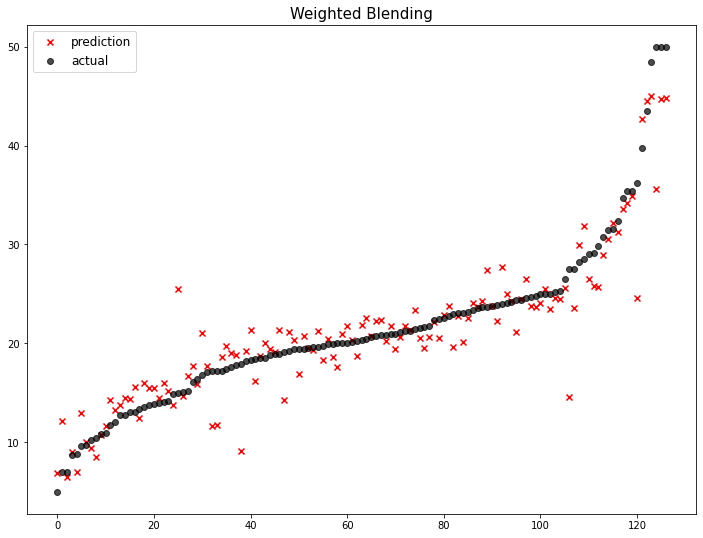

                       model        mse
0   ElasticNet(l1_ratio=0.8)  23.156236
1             Ridge(alpha=1)  22.480476
2          Lasso(alpha=0.01)  22.210557
3           LinearRegression  22.098695
4            Voting Ensemble  22.040224
5                   AdaBoost  16.028607
6                       LGBM  10.937726
7      RandomForest Ensemble  10.761387
8                    XGBoost  10.118980
9                   Stacking   9.786515
10         Weighted Blending   9.570000
11             GradientBoost   8.956141


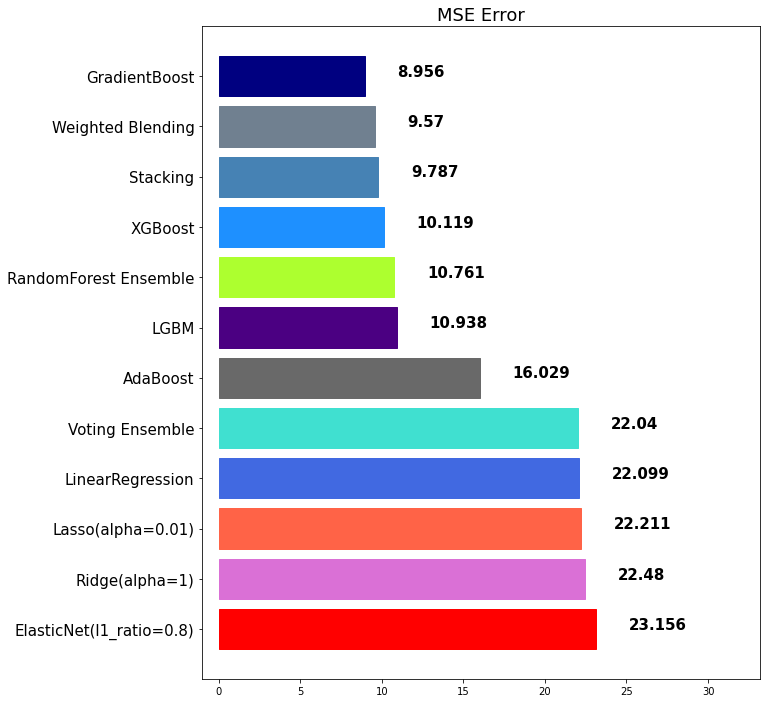

In [ ]:
mse_eval("Weighted Blending", fianl_prediction, y_test)